# Defining torch datasets

In [33]:
import os
os.chdir('/data/l989o/deployed/a')
import sys
if '/data/l989o/a' in sys.path:
    sys.path.remove('/data/l989o/a')
print(os.getcwd())
assert os.path.isdir('data')
current_file_path = os.path.abspath('')
print(current_file_path)

/data/l989o/deployed/a
/data/l989o/deployed/a


In [34]:
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle
import skimage
import skimage.io
import torch
import math
import cv2
import vigra
import pandas as pd
from data import file_path
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
import splits

In [35]:
def file_path_old_data(f):
    return os.path.join(current_file_path, 'data/spatial_uzh_processed', f)


def file_path(f):
    return os.path.join(current_file_path, 'data/spatial_uzh_processed/a', f)

In [36]:
CHANNEL_NAMES = ['H3tot', 'H3met', 'CK5', 'Fibronectin', 'CK19', 'CK8/18', 'TWIST1', 'CD68', 'CK14', 'SMA',
                 'Vimentin', 'Myc', 'HER2', 'CD3', 'H3phospho', 'ERK1/2', 'SLUG', 'ER', 'PR', 'p53', 'CD44',
                 'EpCAM', 'CD45', 'GATA3', 'CD20', 'betaCatenin', 'CAIX', 'Ecadherin', 'Ki67', 'EGFR', 'S6',
                 'Sox9', 'vWf_CD31', 'mTOR', 'CK7', 'panCK', 'cPARP_cCasp3', 'DNA1', 'DNA2']
                 
CHANNELS_TO_KEEP = [8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                    23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
                    36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]

assert len(CHANNEL_NAMES) == len(CHANNELS_TO_KEEP)

In [65]:
def get_split(split):
    assert split in ['train', 'validation', 'test']
    if split == 'train':
        return splits.train
    elif split == 'validation':
        return splits.validation
    else:
        return splits.test

## Ome and masks datasets

In [74]:
class OmeDataset(Dataset):
    def __init__(self, split):
        super().__init__()
        self.split = split
        self.filenames = get_split(self.split)
        self.channels_count = len(CHANNELS_TO_KEEP)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, i):
        filename = self.filenames[i]
        f = os.path.join('data/OMEandSingleCellMasks/ome/', filename)
        ome = skimage.io.imread(f)
        ome = np.moveaxis(ome, 0, 2)
        ome = torch.from_numpy(ome).float()
        ome = ome[:, :, CHANNELS_TO_KEEP]
        ome = ome.float()
        return ome

In [70]:
class MasksDataset(torch.utils.data.Dataset):
    def __init__(self, split):
        self.split = split
        self.filenames = get_split(self.split)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, i):
        ome_filename = self.filenames[i]
        masks_file = file_path_old_data('relabelled_masks.hdf5')
        with h5py.File(masks_file, 'r') as f5:
            masks = f5[ome_filename + '/masks'][...]
        return masks

In [102]:
ds0 = OmeDataset('train')
print(ds0[0].shape)

ds1 = MasksDataset('train')
print(ds1[0].shape)

torch.Size([421, 833, 39])
(421, 833)


## Filtering cells by area


516890 cells in train set


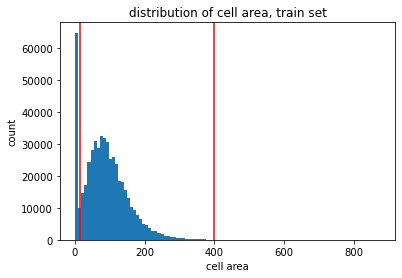


253530 cells in validation set


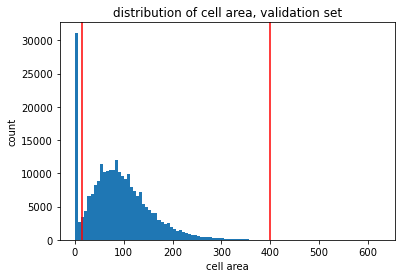


252401 cells in test set


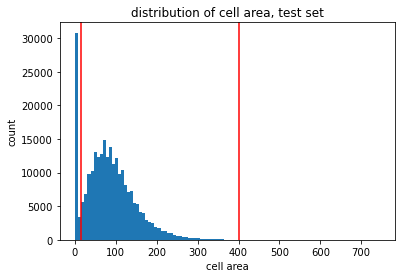

In [125]:
for split in ['train', 'validation', 'test']:
    masks_ds = MasksDataset(split)
    all_areas = []
    all_ome_indices = []
    for masks in tqdm(masks_ds, desc=f'filtering cells by ares, {split} set'):
        m = masks.max()
        all_ome_indices.append(np.array([1] * m))
        for i in range(1, m + 1):
            mask = masks[masks == i]
            assert len(mask.shape) == 1
            all_areas.append(len(mask))

    areas = np.array(all_areas)
    ome_indices = np.concatenate(all_ome_indices)
    assert len(areas) == len(ome_indices)
    print(len(areas), 'cells in', split, 'set')

    min_area = 15
    max_area = 400
    plt.figure()
    plt.hist(areas, bins=100)
    plt.axvline(x=min_area, c='r')
    plt.axvline(x=max_area, c='r')
    plt.xlabel('cell area')
    plt.ylabel('count')
    plt.title(f'distribution of cell area, {split} set')
    plt.show()

    ok_size_cells = (areas >= min_area) & (areas <= max_area)
    pickle.dump(ok_size_cells, open(file_path(f'ok_size_cells_{split}.npy'), 'wb'))

In [158]:
class IndexInfo:
    def __init__(self, split):
        self.split = split
        self.filenames = get_split(self.split)
        
        self.unfiltered_begins = []
        self.unfiltered_ends = []
        self.filtered_begins = []
        self.filtered_ends = []
        ds = MasksDataset(self.split)
        self.ok_size_cells = pickle.load(open(file_path(f'ok_size_cells_{self.split}.npy'), 'rb'))
        i = 0
        j = 0
        for ome_index, masks in enumerate(ds):
            m = masks.max()
            begin = i
            end = begin + m
            i = end
            self.unfiltered_begins.append(begin)
            self.unfiltered_ends.append(end)
            
            ok = self.ok_size_cells[begin: end]
            begin = j
            end = begin + np.sum(ok)
            j = end
            self.filtered_begins.append(begin)
            self.filtered_ends.append(end)
            
{k: IndexInfo(k) for k in ['train', 'validation', 'test']}
print(list(zip(IndexInfo('train').unfiltered_begins, IndexInfo('train').unfiltered_ends)))

[(0, 2890), (2890, 6837), (6837, 10329), (10329, 13396), (13396, 16558), (16558, 19412), (19412, 23385), (23385, 26406), (26406, 28588), (28588, 31308), (31308, 33410), (33410, 36571), (36571, 40158), (40158, 42133), (42133, 45951), (45951, 47831), (47831, 50476), (50476, 54089), (54089, 56795), (56795, 58109), (58109, 59506), (59506, 63100), (63100, 65414), (65414, 68880), (68880, 72861), (72861, 74928), (74928, 77160), (77160, 80587), (80587, 83112), (83112, 86890), (86890, 89639), (89639, 92721), (92721, 96341), (96341, 100298), (100298, 103116), (103116, 105702), (105702, 109013), (109013, 111871), (111871, 114336), (114336, 116059), (116059, 118594), (118594, 122130), (122130, 125803), (125803, 127253), (127253, 130160), (130160, 132185), (132185, 134172), (134172, 137080), (137080, 141030), (141030, 143971), (143971, 145848), (145848, 148504), (148504, 149550), (149550, 152738), (152738, 156246), (156246, 157713), (157713, 161272), (161272, 163490), (163490, 166740), (166740, 170

## Filtering masks

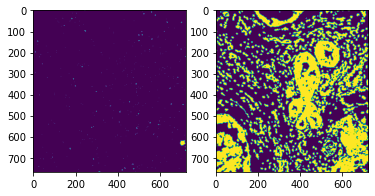

In [188]:
class FilteredMasksDataset(torch.utils.data.Dataset):
    def __init__(self, split):
        self.masks_ds = MasksDataset(split)
        self.index_info = IndexInfo(split)
        
    def __len__(self):
        return len(self.masks_ds)
    
    def __getitem__(self, i):
        masks = self.masks_ds[i]
        m = masks.max()
        v = np.arange(1, m + 1, dtype=np.int)
        begin = self.index_info.unfiltered_begins[i]
        end = self.index_info.unfiltered_ends[i]
        ok = self.index_info.ok_size_cells[begin: end]
        ok_labels = v[ok]
        not_ok = set(v.tolist()).difference(ok_labels.tolist())
        for label in not_ok:
            masks[masks == label] = 0
        return masks

ds0 = MasksDataset('train')    
m0 = ds0[5]
ds1 = FilteredMasksDataset('train')
m1 = ds1[5]

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(m0 != m1)
plt.subplot(1, 2, 2)
plt.imshow((m0 == m1) & (m0 != 0))
plt.show()

## Hot pixel removalclass OmeDataset(Dataset):

In [178]:
class OmeDataset(Dataset):
    def __init__(self, split):
        super().__init__()
        self.split = split
        self.filenames = get_split(self.split)
        self.channels_count = len(CHANNELS_TO_KEEP)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, i):
        filename = self.filenames[i]
        f = os.path.join('data/OMEandSingleCellMasks/ome/', filename)
        ome = skimage.io.imread(f)
        ome = np.moveaxis(ome, 0, 2)
        ome = torch.from_numpy(ome).float()
        ome = ome[:, :, CHANNELS_TO_KEEP]
        ome = ome.float()
        
        kernel = np.ones((3, 3), dtype=np.uint8)
        kernel[1, 1] = 0
        maxs = cv2.dilate(ome, kernel, iterations=1, borderType=cv2.BORDER_REFLECT101)
        mask = ome - maxs >= 50
        c = ome[mask] - maxs[mask]
        a = np.sum(c)
        b = np.sum(ome)
        ome[mask] = maxs[mask]

        ome = torch.from_numpy(ome).float()
        return ome, np.sum(mask), ome.numel(), a, b
        return ome